In [1]:
import csv
import pandas as pd
import numpy as np
%config Completer.use_jedi = False

In [2]:
class KNearestNeighbors:
    import numpy as np
    from collections import Counter as cnt

    def __init__(self, k, distance_metric="euclidean", weights="uniform"):
        """initialize the knn algorithm
        :param k: size of neighbors, integer
        :param distance_metric: type of distance measure
            possible options ('euclidean' - default,'cosine','manhattan')
        :param weights: voting preference, either uniform or weighted
        """
        self.k = k
        self.distance_metric = distance_metric
        self.weights = weights

    def fit(self, X, y):
        """
        Store the 'prior knowledge' of you model that will be used
        to predict new labels.
        :param X : input data points, ndarray, shape = (R,C).
        :param y : input labels, ndarray, shape = (R,).
        """
        self.tr_data = X
        self.tr_labels = y

    def predict(self, X):
        """Run the KNN classification on X.
        :param X: input data points, ndarray, shape = (N,C).
        :return: labels : ndarray, shape = (N,).
        """
        N = 1 if X.ndim == 1 else len(X)
        p_labels = []
        distance_options = {
            'euclidean': self.euclidean_distance,
            'cosine': self.cosine_distance,
            'manhattan': self.manhattan_distance
        }

        distance = distance_options[self.distance_metric]
        for p in X:
            d = distance(self.tr_data, p)
            k_min_dist_ixs = np.argpartition(d, self.k, axis=-1)[:self.k]
            label = self.voted_label(
                self.tr_labels[k_min_dist_ixs], d[k_min_dist_ixs])
            p_labels.append(label)

        return p_labels

    def voted_label(self, labels, dist):
        """Returns the labels with maximum votes based on weighting criteria
        labels: labels of k-nearest neighbors
        dist: distances of k-nearest neighbors
        """
        from collections import defaultdict
        
        weighted_votes = defaultdict(float)
        for l, d in zip(labels, dist):
            weighted_votes[l] += 1.0 if self.weights == 'uniform' else 1 / (d+1)
        return max(weighted_votes, key=weighted_votes.get)

    def euclidean_distance(self, x, y):
        return np.sqrt(np.sum((x-y)**2, axis=-1, dtype=np.float))

    def cosine_distance(self, x, y):
        def cosine_sim(x, y):
            n = np.sum(x*y, axis=-1)
            d = (np.sqrt(np.sum(x**2, axis=-1, dtype=np.float))
                 * np.sqrt(np.sum(y**2, axis=-1, dtype=np.float)))
            return n/d

        return 1 - cosine_sim(x, y)

    def manhattan_distance(self, x, y):
        return np.sum(np.abs(x-y), axis=-1)

## label classification on IRIS dataset


In [3]:
df = pd.read_csv(r'iris.csv', header=None)
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
data = df.values
data[:5]

array([[5.1, 3.5, 1.4, 0.2, 'Iris-setosa'],
       [4.9, 3.0, 1.4, 0.2, 'Iris-setosa'],
       [4.7, 3.2, 1.3, 0.2, 'Iris-setosa'],
       [4.6, 3.1, 1.5, 0.2, 'Iris-setosa'],
       [5.0, 3.6, 1.4, 0.2, 'Iris-setosa']], dtype=object)

In [5]:
N = len(data)
K = N//5  # test size
N, K

(150, 30)

In [6]:
K_index = np.random.randint(0, N, K)
X_test = data[K_index, :-1]
Y_test = data[K_index, -1]
X_test.shape, Y_test.shape #test set

((30, 4), (30,))

In [7]:
mask = np.ones(N, bool)
mask[K_index] = False
X_train = data[mask][:, :-1]
Y_train = data[mask][:, -1]
k,d  = 5, 'euclidean'
knn = KNearestNeighbors(k, d)
knn.fit(X_train, Y_train)
predicted_labels = knn.predict(X_test)
correctly_predicted = (predicted_labels == Y_test ).sum()
accuracy = correctly_predicted / K
print(f'using k = {k} with euclidean distance and uniform weights; accuracy = {accuracy*100}')

using k = 5 with euclidean distance and uniform weights; accuracy = 96.66666666666667


In [8]:
results = []
for k in (np.arange(2,51,3)):
    for d in ('euclidean','cosine','manhattan'):
        for vote_type in ('uniform', 'weighted'):
            knn = KNearestNeighbors(k, d, vote_type)
            knn.fit(X_train, Y_train)
            predicted_labels = knn.predict(X_test)
            correctly_predicted = (predicted_labels == Y_test ).sum()
            accuracy = correctly_predicted / K
            results.append((k,d,vote_type,accuracy*100))

cols = ['K', 'Distance', 'weights','accuracy']
df = pd.DataFrame(data = results, columns= cols)
df.sort_values(by = 'accuracy', ascending= False).head(10)

,K,Distance,weights,accuracy
101,50,manhattan,weighted,100.0
83,41,manhattan,weighted,100.0
79,41,euclidean,weighted,100.0
24,14,euclidean,uniform,100.0
25,14,euclidean,weighted,100.0
77,38,manhattan,weighted,100.0
30,17,euclidean,uniform,100.0
31,17,euclidean,weighted,100.0
73,38,euclidean,weighted,100.0
72,38,euclidean,uniform,100.0


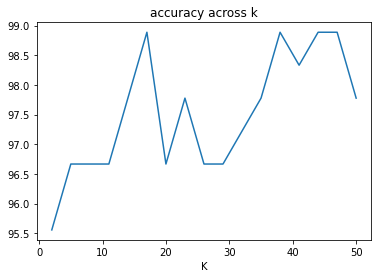

In [9]:
df.groupby(df.K)["accuracy"].mean().plot(title = 'accuracy across k');

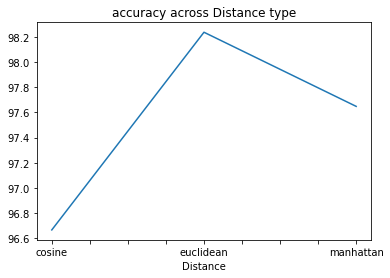

In [10]:
df.groupby(df.Distance)["accuracy"].mean().plot(title = 'accuracy across Distance type');

## Label Classification over MNIST dataset

In [11]:
mnist_df = pd.read_csv('mnist.csv', header = None)
sample = mnist_df.groupby(0).apply(lambda x: x.sample(n=100)).reset_index(drop = True)
data = sample.values
N = len(data)

test_factor = 0.2
test_index = np.array([True]*int(N*test_factor) + [False]*int(N * (1 - test_factor)))
np.random.shuffle(test_index)

X_test = data[test_index, 1:]
Y_test = data[test_index, 0]
X_train = data[~test_index, 1:]
Y_train = data[~test_index, 0]


In [12]:
k,d  = 5, 'euclidean'
test_size = test_index.sum()
knn = KNearestNeighbors(k, d)
knn.fit(X_train, Y_train)
predicted_labels = knn.predict(X_test)
correctly_predicted = (predicted_labels == Y_test ).sum()
accuracy = correctly_predicted / test_size
print(f'using k = {k} with euclidean distance and uniform weights; accuracy = {accuracy*100}%')

using k = 5 with euclidean distance and uniform weights; accuracy = 88.5%


In [13]:
results = []
for k in (np.arange(5,31,5)):
    for d in ('euclidean','cosine','manhattan'):
        for vote_type in ('uniform', 'weighted'):
            knn = KNearestNeighbors(k, d, vote_type)
            knn.fit(X_train, Y_train)
            predicted_labels = knn.predict(X_test)
            correctly_predicted = (predicted_labels == Y_test ).sum()
            accuracy = correctly_predicted / test_size
            results.append((k,d,vote_type,accuracy*100))

cols = ['K', 'Distance', 'weights','accuracy']
df = pd.DataFrame(data = results, columns= cols)
df.sort_values(by = 'accuracy', ascending= False).head(10)

,K,Distance,weights,accuracy
2,5,cosine,uniform,93.0
3,5,cosine,weighted,93.0
7,10,euclidean,weighted,89.0
9,10,cosine,weighted,89.0
1,5,euclidean,weighted,89.0
0,5,euclidean,uniform,88.5
4,5,manhattan,uniform,88.5
15,15,cosine,weighted,88.5
14,15,cosine,uniform,88.0
6,10,euclidean,uniform,88.0


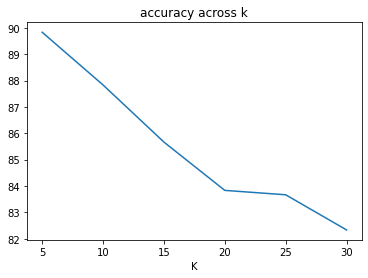

In [14]:
df.groupby(df.K)["accuracy"].mean().plot(title = 'accuracy across k');

In [15]:
testset = sample.sample(frac= 0.2)
trainset = sample.loc[sample.index.difference(testset.index)]
testset.shape,trainset.shape

((200, 785), (800, 785))